In [1]:
# Install required packages
%pip install xarray netCDF4 matplotlib cartopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the CESM terrain data file and select United States region
file_path = 'fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_031819.nc'

# United States region: focused coverage
# Latitude: 24°N to 50°N (covers continental US)
# Longitude: 235°E to 300°E (converts to -125°W to -60°W, covers US from Pacific to Atlantic)
ds = xr.open_dataset(file_path)
us_subset = ds.sel(lat=slice(24, 50), lon=slice(235, 300))

# Only keep PHIS variable we need, drop the rest to save memory
ds = us_subset[['PHIS']]

print("United States subset shape:", ds.PHIS.shape)
print("Latitude range:", float(ds.lat.min()), "to", float(ds.lat.max()))
print("Longitude range:", float(ds.lon.min()), "to", float(ds.lon.max()))

United States subset shape: (13, 27)
Latitude range: 25.57894736842104 to 48.31578947368419
Longitude range: 235.0 to 300.0


In [3]:
# Convert geopotential (PHIS) to elevation in meters
# PHIS is in m²/s², divide by gravity (9.8065 m/s²) to get elevation
g0 = 9.8065  # Standard gravity in m/s²
ds["elevation"] = ds.PHIS / g0

# Load the data into memory now (only the subset we need)
ds = ds.load()

# Check the elevation data (verify units are in meters)
print("Elevation range:", float(ds.elevation.min().values), "to", float(ds.elevation.max().values), "meters")
print("(Verified: elevation is in meters, converted from PHIS geopotential)")

# This represents how CESM stores elevation: discrete values at each grid cell center
# The model uses these exact values for terrain-following calculations

Elevation range: 0.0 to 2294.470000660212 meters
(Verified: elevation is in meters, converted from PHIS geopotential)


CESM f19 grid spacing: lat=1.895°, lon=2.500°
Data shape: (13, 27) (lat × lon grid cells)


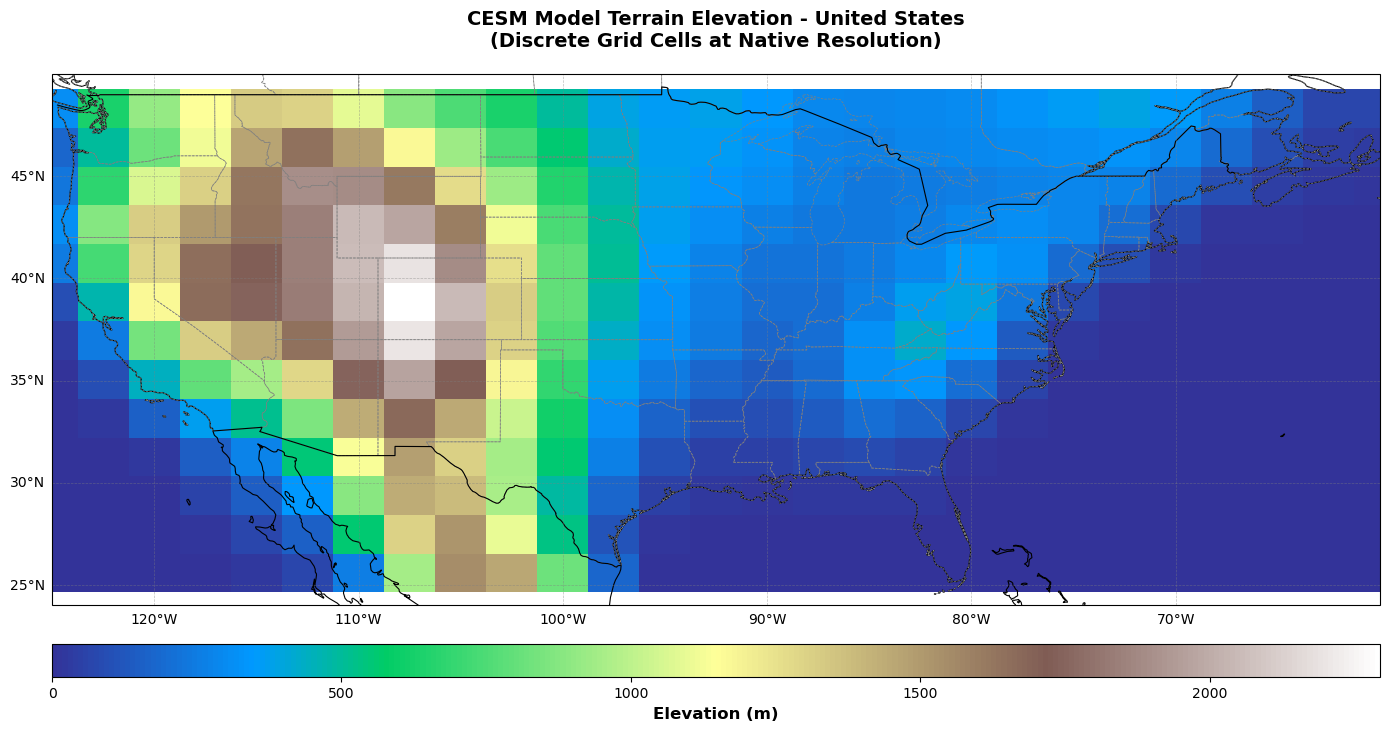

In [4]:
# Create a high-resolution plot showing CESM model elevation for the United States
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get coordinate values (before wrapping longitude)
lon_values_raw = ds.lon.values
lat_values = ds.lat.values
elevation_values = ds.elevation.values

# Convert longitude from 0-360 format to -180-180 format for plotting
# Use np.where to safely wrap only values > 180
lon_values = np.where(lon_values_raw > 180, lon_values_raw - 360, lon_values_raw)

# Compute grid spacing from coordinate arrays themselves (accurate for f19 grid)
lon_spacing = np.diff(lon_values_raw).mean()
lat_spacing = np.diff(lat_values).mean()

print(f"CESM f19 grid spacing: lat={lat_spacing:.3f}°, lon={lon_spacing:.3f}°")
print(f"Data shape: {elevation_values.shape} (lat × lon grid cells)")

# Create edge coordinates for pcolormesh (required for discrete grid cell representation)
# pcolormesh shows each grid cell as a discrete unit, matching how CESM uses elevation
lon_edges_raw = np.concatenate([[lon_values_raw[0] - lon_spacing/2], 
                                 lon_values_raw + lon_spacing/2])
lat_edges = np.concatenate([[lat_values[0] - lat_spacing/2], 
                            lat_values + lat_spacing/2])

# Wrap longitude edges the same way as cell centers
lon_edges = np.where(lon_edges_raw > 180, lon_edges_raw - 360, lon_edges_raw)

# Create the plot using pcolormesh to show discrete grid cells without smoothing
# This accurately represents how CESM views elevation: each grid cell has a single elevation value
im = ax.pcolormesh(lon_edges, lat_edges, elevation_values, 
                   cmap='terrain', transform=ccrs.PlateCarree(), shading='auto')

# Add coastlines and political boundaries
ax.coastlines(resolution='50m', linewidth=0.8, color='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')

# Set the map extent to focus on the United States
ax.set_extent([-125, -60, 24, 50], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Elevation (m)', fontsize=12, fontweight='bold')

# Add title
plt.title('CESM Model Terrain Elevation - United States\n(Discrete Grid Cells at Native Resolution)', 
          fontsize=14, fontweight='bold', pad=20)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.tight_layout()
plt.show()

In [5]:
# Save as high-resolution PNG
output_file = 'CESM_terrain_US.png'
fig.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"High-resolution plot saved as: {output_file}")
print("This plot accurately represents how CESM uses elevation data:")
print("- Each grid cell contains one elevation value")
print("- No interpolation or smoothing between cells")
print("- Exact same resolution as model calculations")

High-resolution plot saved as: CESM_terrain_US.png
This plot accurately represents how CESM uses elevation data:
- Each grid cell contains one elevation value
- No interpolation or smoothing between cells
- Exact same resolution as model calculations
